<a id='imp'></a>
## Importing packages and loading data

In [5]:
# Input data files are available in the "../input/" directory.
import os
#print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# loading data
df = pd.read_csv('complaints.csv')
df.shape

(4060417, 18)

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [7]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-08-23,2023-08-23
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Sub-product,Credit reporting,Credit reporting
Issue,Incorrect information on your report,Improper use of your report
Sub-issue,Information belongs to someone else,Reporting company used your report improperly
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,Experian Information Solutions Inc.,Experian Information Solutions Inc.
State,OH,PA
ZIP code,44143,19145


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [8]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1470283, 2)

In [9]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [10]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Vehicle loan or lease'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit card'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Payday loan'],
       ['Consumer Loan'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [11]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [12]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [13]:
# we need to classify the data into four categories only 
categories = ['Credit reporting, repair, or other','Debt collection','Consumer Loan','Mortgage']

df2 = df2[df2['Product'].isin(categories)]
df2['Product'].unique()

array(['Debt collection', 'Credit reporting, repair, or other',
       'Mortgage', 'Consumer Loan'], dtype=object)

In [14]:
pd.DataFrame(df2.Product.unique())

,0
0,Debt collection
1,"Credit reporting, repair, or other"
2,Mortgage
3,Consumer Loan


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [15]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
2887865,Debt collection,"Since last XXXX , Commonwealth Financial has...",0
1013335,"Credit reporting, repair, or other","I pulled my credit report on XX/XX/19, upon re...",1
1216800,"Credit reporting, repair, or other","According to FCRA 609 ( a ) ( 1 ) ( A ), Finan...",1
952058,"Credit reporting, repair, or other",Chase Auto Finance advised that they received ...,1
454583,Debt collection,Requested original alleged contract with origi...,0


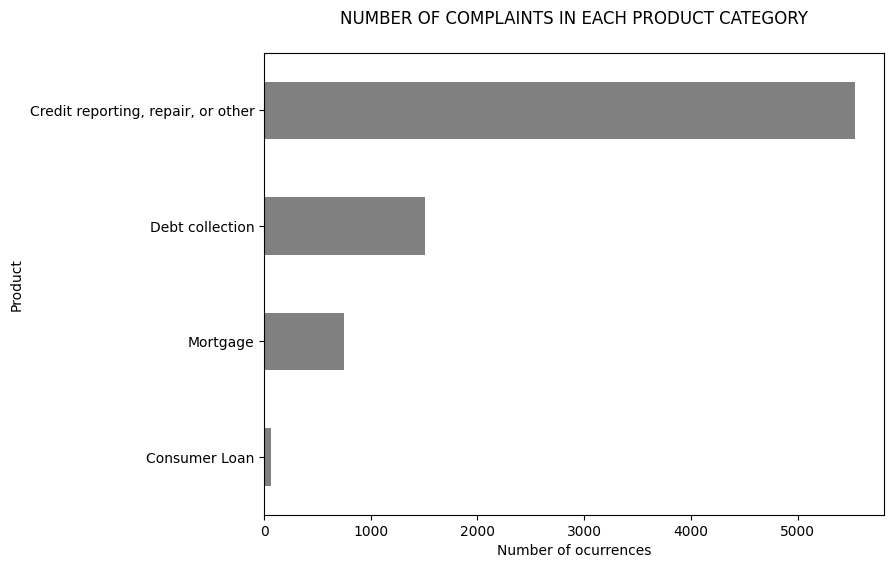

In [16]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 7852 complaints is represented by 19712 features (TF-IDF score of unigrams and bigrams)


In [19]:
import numpy as np
from sklearn.feature_selection import chi2

# Perform chi-squared test
features_chi2 = chi2(features, labels == category_id)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names_out())[indices]  # Corrected line

# Continue with the rest of your code
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]


<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [21]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [22]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [23]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.898624,0.005804
RandomForestClassifier,0.705553,0.000513


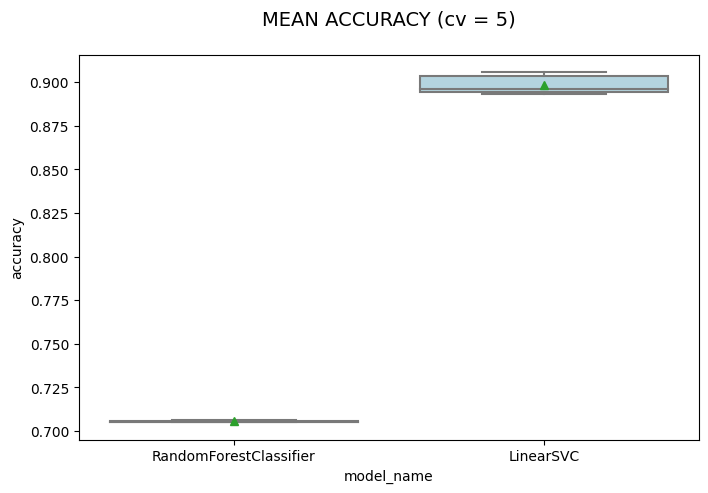

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [25]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [27]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                    precision    recall  f1-score   support

                   Debt collection       0.82      0.78      0.80       369
Credit reporting, repair, or other       0.93      0.96      0.94      1390
                          Mortgage       0.91      0.87      0.89       188
                     Consumer Loan       0.00      0.00      0.00        16

                          accuracy                           0.91      1963
                         macro avg       0.67      0.65      0.66      1963
                      weighted avg       0.90      0.91      0.90      1963



c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91727\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

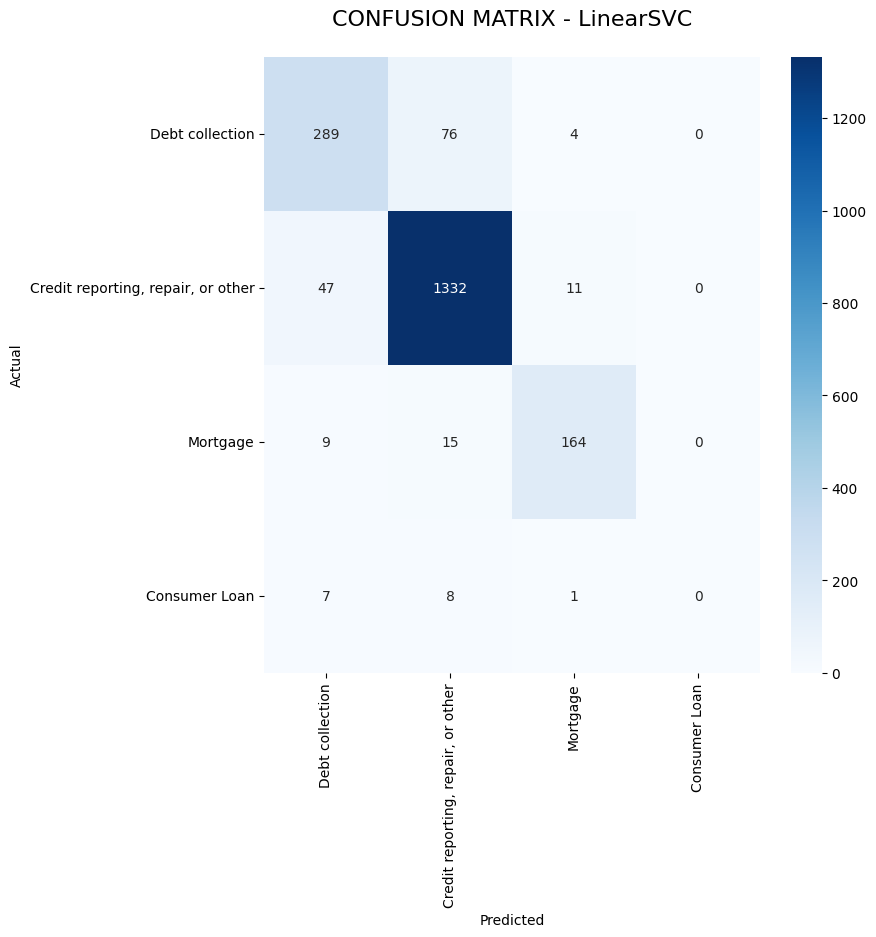

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [30]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Credit reporting, repair, or other' predicted as 'Debt collection' : 47 examples.


,Product,Consumer_complaint
1796854,"Credit reporting, repair, or other","On the date of XX/XX/2020, I signed a consumer..."
3478464,"Credit reporting, repair, or other",I HAVE NOT RECIEVED ANY VERIFICATION OF DEBT O...
3597949,"Credit reporting, repair, or other",I recently noticed a lot of charges on existin...
751316,"Credit reporting, repair, or other",I was living at apartment ; they reported not ...
1396860,"Credit reporting, repair, or other",I 've been trying to submit complaints to EXPE...
1755966,"Credit reporting, repair, or other",There is an item on my credit report from XXXX...
2149491,"Credit reporting, repair, or other","Dear CFPB, This letter is in reference to acco..."
3994735,"Credit reporting, repair, or other",There was confusion on why a collection agency...
1484008,"Credit reporting, repair, or other",This complaint is related to XXXX prior compla...
1209880,"Credit reporting, repair, or other",I owned this car for 3 months and totaled it i...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 76 examples.


,Product,Consumer_complaint
818771,Debt collection,I am a federally protected consumer and Navy F...
3171010,Debt collection,This kind of account is placed as a charged of...
3707625,Debt collection,I recently reviewed my credit reports and I ha...
3554294,Debt collection,Name of Creditor : RISE Address : XXXX XXXX XX...
569968,Debt collection,I filed this complaint with the FTC # XXXX on ...
...,...,...
1007749,Debt collection,An account with Capital One was opened with a ...
3094618,Debt collection,I have 2 accounts on my credit report that I h...
1404391,Debt collection,I spoke with Employee ID # XXXX regarding a pu...
110057,Debt collection,In accordance with the Fair credit reporting a...


#### Most correlated terms with each category

In [31]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [ ]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint_2]